<a href="https://colab.research.google.com/github/sachaRfd/Circle-Detector/blob/main/Circle_locator_ML_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook Explaining the functions given by SlingShot: 

In [247]:
# Imports: 
from functions import *
!pip install livelossplot
!pip install tensorboard

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from livelossplot import PlotLosses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


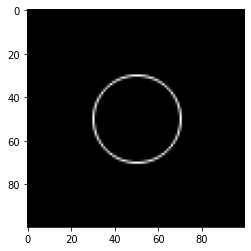

In [248]:
# Draw Circle: 

# create a numpy array of zeros with shape (100, 100)
img = np.zeros((100, 100))

# draw a circle with center (50, 50) and radius 20 in the numpy array
img = draw_circle(img, 50, 50, 20)

# show the numpy array with the circle using matplotlib
plt.imshow(img, cmap='gray')
plt.show()

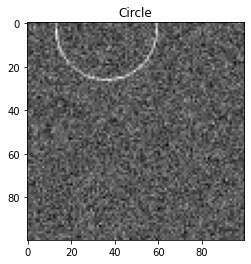

CircleParams(row=3, col=36, radius=23)


In [249]:
# Random Circle with noise: 
# generate a random circle with radius between 10 and 30, centered at a random point
# with a noise level of 0.2
img, circle_params = noisy_circle(img_size=100, min_radius=10, max_radius=30, noise_level=0.2)

# show the generated circle
show_circle(img)

# print the center point and radius of the circle
print(circle_params)


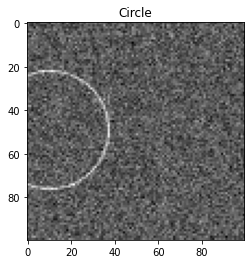

CircleParams(row=49, col=10, radius=27)


In [250]:
# generate a random circle with radius between 10 and 30, centered at a random point
# with a noise level of 0.2
img, circle_params = noisy_circle(img_size=100, min_radius=10, max_radius=30, noise_level=0.2)

# show the generated circle
show_circle(img)

# print the center point and radius of the circle
print(circle_params)


Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'


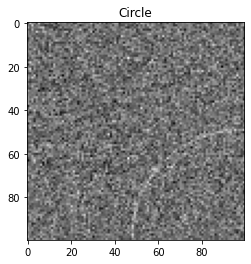

Row: 98, Col: 97, Radius: 49


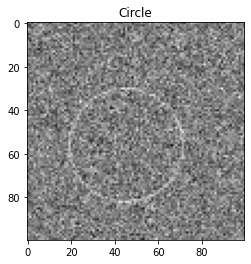

Row: 56, Col: 45, Radius: 26


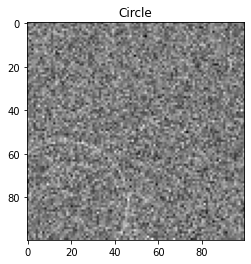

Row: 83, Col: 17, Radius: 29


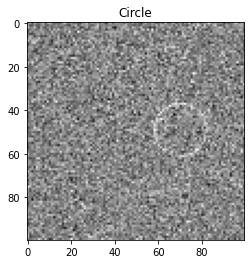

Row: 49, Col: 70, Radius: 12


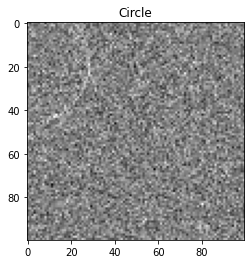

Row: 18, Col: 0, Radius: 28


In [251]:
# Create a generator with default parameters
example_generator = generate_examples()

# Generate 5 examples
for i in range(5):
    # Get the next example from the generator
    img, params = next(example_generator)
    
    # Display the image and its parameters
    show_circle(img)
    print(f"Row: {params.row}, Col: {params.col}, Radius: {params.radius}")

In [252]:
# Define two circles
circle1 = CircleParams(row=50, col=50, radius=20)
circle2 = CircleParams(row=51, col=50, radius=15)

# Calculate the intersection over union of the circles
iou_value = iou(circle1, circle2)

# Print the result
print(f"Intersection over union: {iou_value}")

Intersection over union: 1


First off, let's create the custom dataset class:

In [253]:
import torch
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset for the circle images
class CircleDataset(Dataset):
    def __init__(self, noise_level, img_size, min_radius=None, max_radius=None):
        self.generator = generate_examples(noise_level=noise_level, img_size=img_size, min_radius=min_radius, max_radius=max_radius)
        self.length = 1000  # Set the length to a fixed number, e.g., 1000

    def __getitem__(self, idx):
        img, params = next(self.generator)
        return img, torch.tensor(params)

    def __len__(self):
        return self.length
        
# Define the train dataset and dataloader
train_dataset = CircleDataset(noise_level=0.5, img_size=100, min_radius=10, max_radius=50)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the test dataset and dataloader
test_dataset = CircleDataset(noise_level=0.5, img_size=100, min_radius=10, max_radius=50)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'


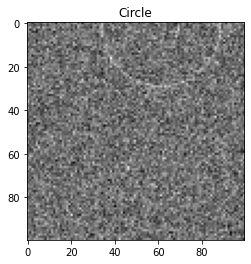

tensor([36, 97, 19])


In [254]:
show_circle(next(iter(train_loader))[0][0])
print(next(iter(train_loader))[1][0])

# Now For the steps: 
- create data set and loaders: 

In [255]:
class CircleDataset(Dataset):
    def __init__(self, noise_level, img_size, min_radius=None, max_radius=None):
        self.generator = generate_examples(noise_level=noise_level, img_size=img_size, min_radius=min_radius, max_radius=max_radius)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5),
        ])
        self.length = 1000  # Started with 100


    def __getitem__(self, idx):
        img, params = next(self.generator)
        img_tensor = self.transform(img)
        params_tensor = torch.tensor([params.row, params.col, params.radius])
        return img_tensor, params_tensor

    def __len__(self):
        return self.length



Let's get a basic model running: 

In [276]:
# class CircleDetector(nn.Module):
#     def __init__(self):
#         super(CircleDetector, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(1, 64, 3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.Mish(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(64, 128, 3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.Mish(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(128, 256, 3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.Mish(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(256, 512, 3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.Mish(),
#             nn.MaxPool2d(2),
#         )

#         self.fc = nn.Sequential(
#             nn.Linear(512 * 6 * 6, 512),
#             nn.BatchNorm1d(512),
#             nn.Mish(),
#             nn.Linear(512, 3),
#         )

#     def forward(self, x):
#         x = x.float()
#         x = self.conv(x)
#         x = x.view(-1, 512 * 6 * 6)
#         x = self.fc(x)
#         return x

class CircleDetector(nn.Module):
    def __init__(self):
        super(CircleDetector, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.Mish(),
            nn.MaxPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.Mish(),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.Mish(),
            nn.MaxPool2d(2),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.Mish(),
            nn.MaxPool2d(2),
        )

        self.fc = nn.Sequential(
            nn.Linear(256 * 3 * 3, 256),
            nn.BatchNorm1d(256),
            nn.Mish(),
            nn.Linear(256, 3),
        )

        self.skip1 = nn.Conv2d(1, 32, 1)
        self.skip2 = nn.Conv2d(32, 64, 1)
        self.skip3 = nn.Conv2d(64, 128, 1)

    def forward(self, x):
        x = x.float()
        skip1 = self.skip1(x)
        x = self.conv1(x)
        x = x + skip1
        skip2 = self.skip2(x)
        x = self.conv2(x)
        x = x + skip2
        skip3 = self.skip3(x)
        x = self.conv3(x)
        x = x + skip3
        x = self.conv4(x)
        x = x.view(-1, 256 * 3 * 3)
        x = self.fc(x)
        return x

Let's setup our train, test and evaluate functions: 

In [257]:
def loss_function(model_output, true_output):
  # Loss function for IoU: 
  true_circle = true_output
  eval_params = model_output
  model_circle = CircleParams(row=eval_params[0][0], col=eval_params[0][1], radius=eval_params[0][2]) 
  iou_value = iou(circle1, circle2)
  return iou_value

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    liveplot = PlotLosses()
    for i, (img, params) in enumerate(train_loader):
        img, params = img.to(device), params.to(device)
        img = img.float().to(device)
        params = params.float().to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, params)
        loss.backward()
        optimizer.step()
    return loss / len(train_loader.dataset)


def test(model, test_loader, criterion, device, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (img, params) in enumerate(test_loader):
            img, params = img.to(device), params.to(device)
            output = model(img)
            loss = criterion(output, params)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_loader)
    print(f"Epoch {epoch}, Average test loss: {avg_test_loss}")    
    return avg_test_loss
  
def evaluate(model, noise_level):
  transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5),
        ])
  img_size = 100
  example_generator = generate_examples(noise_level=noise_level, img_size=img_size, min_radius=10, max_radius=50)
  img_test, params_test = next(example_generator)
  show_circle(img_test)
  print('Real Parameters for above Circle', params_test)
  model.eval()
  eval_params = model(transform(img_test).reshape((1, 1, 100, 100)).to(device))
  eval_params = eval_params.cpu().detach().numpy()
  print('Predicted Parameters {}'.format(eval_params))
  # Create an empty image
  img = np.zeros((img_size, img_size))
  img = draw_circle(img, row=int(eval_params[0][0]), col=int(eval_params[0][1]), radius=int(eval_params[0][2]))
  show_circle(img)


  # Define two circles
  circle1 = params_test # True circle
  circle2 = CircleParams(row=eval_params[0][0], col=eval_params[0][1], radius=eval_params[0][2])  # Model Circle
  # Calculate the intersection over union of the circles
  iou_value = iou(circle1, circle2) 
  # Print the result
  print(f"Intersection over union: {iou_value}")

# Training Setup: 

In [275]:
from livelossplot import PlotLosses
import matplotlib.pyplot as plt


liveloss = PlotLosses()  # Setup for loss Curve


# Create the model
model = CircleDetector().to(device)
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters in the model: {num_params}")


# Hyper-parameters: 
num_epochs = 10
batch_size = 64
lr = 0.01
noise_level = 0.4   # between 0 and 1

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion =   nn.MSELoss()


# Define the train and test datasets and dataloaders
train_dataset = CircleDataset(noise_level=noise_level, img_size=100, min_radius=10, max_radius=50)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CircleDataset(noise_level=noise_level, img_size=100, min_radius=10, max_radius=50)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


for epoch in range(num_epochs):
    # Train the model and get the train loss
    logs = {}
    train_loss = train(model, train_loader, optimizer, criterion, device)
    logs['' + 'log loss'] = train_loss.item()
    # Evaluate the model
    test_loss = test(model, test_loader, criterion, device, epoch)
    logs['' + 'test loss'] = test_loss
    
    # Update the liveplot and draw
    liveloss.update(logs)
    liveloss.draw()

Number of parameters in the model: 990659
Using parameters: noise_level=0.4, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'


TypeError: ignored

# Evaluate the model: 

Using parameters: noise_level=0.4, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'


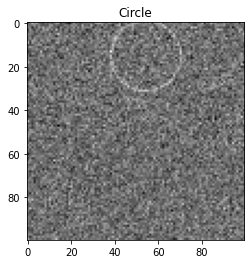

Real Parameters for above Circle CircleParams(row=15, col=54, radius=16)
Predicted Parameters [[ 5.015952 53.83607  19.67969 ]]


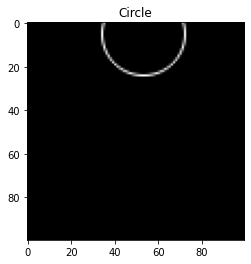

Intersection over union: 0.8896685699383751


In [264]:
evaluate(model, noise_level=noise_level)

# My training idea: 
- start with circle with little noise --> train until loss converges  / Or even no noise with code: # Draw Circle: img = np.zeros((100, 100));img = draw_circle(img, 50, 50, 20); plt.imshow(img, cmap='gray')
plt.show()
- make dataloader with more noise
- Train egain
- Repeat multiple times

- Potentially also look into smaller radii that do not go out of the picture
- Make function inside evaluate that checks IoU50
  - Potentially look into implement IoU50 into Loss


- Look into YoloV5/V1 model architecture. 